In [1]:
import gym
import gym.spaces
from gym.utils import seeding
from gym.envs.registration import EnvSpec
import enum
import numpy as np
import pandas as pd
from pathlib import Path
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

In [2]:
from gym import Env
from gym.spaces import Discrete, Box
import random

In [3]:
class Actions(enum.Enum):
    Skip = 0
    Buy = 1
    Close = 2

In [4]:
DEFAULT_BARS_COUNT = 50
DEFAULT_COMMISSION_PERC = 0.0025

In [5]:
class EAM_Env(Env):
    metadata = {'render.modes': ['human']}
    spec = EnvSpec('StocksEnv-v0') #not quite sure what this does, but 
    #i might change the name
    
    def __init__(self, prices, bars_count=DEFAULT_BARS_COUNT,
                commission_perc=DEFAULT_COMMISSION_PERC, state_1d=True,
                random_ofs_on_reset=True, reward_on_close=True):
        
        #assert isinstance(prices, dict)
        self._prices = prices
        bars_count = int(bars_count)
        
        if state_1d:
            self._state = State1D(prices,
                bars_count=DEFAULT_BARS_COUNT, commission_perc=DEFAULT_COMMISSION_PERC,
                reward_on_close=reward_on_close)
        else:
            self._state = State(prices,
                bars_count=DEFAULT_BARS_COUNT, commission_perc=DEFAULT_COMMISSION_PERC,
                reward_on_close=reward_on_close)
            
        #Actions
        self.action_space = Discrete(n=len(Actions))
        #Observation array    
        self.observation_space = Box(low=-np.inf, high=np.inf,
                                    shape=self._state.shape, 
                                     dtype=np.float32)
        
        self.random_ofs_on_reset = random_ofs_on_reset
        self.seed()
        
    def step(self, action, pass_on):
        reward, done = self._state.step(action, pass_on)
        obs = self._state.encode()
        info = {
            #figure out what to do for info
            'offset': self._state._offset
        }
        return obs, reward, done, info
        
    def reset(self):
        prices = self._prices
        bars = self._state.bars_count
        if self.random_ofs_on_reset:
            offset = np.random.choice(
                prices.close.shape[0]-bars*10) + bars
        else:
            offset = bars
        self._state.reset(prices, offset)
        return self._state.encode()
    
    def render(self, mode='human', close=False):
        pass
    
    def close(self):
        pass
    
    def seed(self, seed=None):
        self.n_random, seed1 = seeding.np_random(seed)
        seed2 = seeding.hash_seed(seed1 + 1) % 2 ** 31
        return [seed1, seed2]
    
    @classmethod
    def from_dir(cls, data_dir, **kwargs):
        prices = {
            file: data.load_relative(file)
            for file in data.price_files(data_dir)
        }
        return EAM_Env(prices, **kwargs)

In [6]:
DATA_STORE = 'research.h5'

In [7]:
class State:
    def __init__(self, prices, bars_count, commission_perc,
                 reward_on_close=True):
        assert isinstance(bars_count, int)
        assert bars_count > 0
        assert isinstance(commission_perc, float)
        assert commission_perc >= 0.0
        assert isinstance(reward_on_close, bool)
        self.bars_count = bars_count
        self.commission_perc = commission_perc
        self.reward_on_close = reward_on_close
        
        
    def reset(self, prices, offset):
        assert isinstance(prices, pd.DataFrame)
        assert offset >= self.bars_count-1
        self.have_position = False
        self.position = 0
        self.position_buyin_tot_value = 0.0
        self._prices = prices
        self._offset = offset
        self.reward_cumsum = 0
        
    @property
    def shape(self):
        # [c, h, l, o, ...] * bars + position_flag + rel_profit
        return 20 * self.bars_count + 1 + 1
    
    def encode(self):
        #Convert current state into numpy array.
        
        res = np.ndarray(shape=self.shape, dtype=np.float32)
        shift = 0
        #start_index_value = -self.bars_count + 1 + self._offset
        for bar_idx in range(-self.bars_count+1, 1):
            ofs = self._offset + bar_idx
            res[shift] = self._prices.close[ofs] #/self._prices.close[start_index_value]
            shift += 1
            res[shift] = self._prices.high[ofs] #/self._prices.high[start_index_value]
            shift += 1
            res[shift] = self._prices.low[ofs] #/self._prices.low[start_index_value]
            shift += 1
            res[shift] = self._prices.open[ofs] #/self._prices.open[start_index_value]
            shift += 1
            res[shift] = self._prices.volume[ofs] #/self._prices.volume[start_index_value]
            shift += 1
            res[shift] = self._prices.OPM[ofs] #/self._prices.OPM[start_index_value]
            shift += 1
            res[shift] = self._prices.NPM[ofs] #/self._prices.NPM[start_index_value]
            shift += 1
            res[shift] = self._prices.ROA[ofs] #/self._prices.ROA[start_index_value]
            shift += 1
            res[shift] = self._prices.ROE[ofs] #/self._prices.ROE[start_index_value]
            shift += 1
            res[shift] = self._prices.cur_ratio[ofs] #/self._prices.cur_ratio[start_index_value]
            shift += 1
            res[shift] = self._prices.quick_ratio[ofs] #/self._prices.quick_ratio[start_index_value]
            shift += 1
            res[shift] = self._prices.cash_ratio[ofs] #/self._prices.cash_ratio[start_index_value]
            shift += 1
            res[shift] = self._prices.inv_turnover[ofs] #/self._prices.inv_turnover[start_index_value]
            shift += 1
            res[shift] = self._prices.acc_rec_turnover[ofs] #/self._prices.acc_rec_turnover[start_index_value]
            shift += 1
            res[shift] = self._prices.acc_pay_turnover[ofs] #/self._prices.acc_pay_turnover[start_index_value]
            shift += 1
            res[shift] = self._prices.debt_ratio[ofs] #/self._prices.debt_ratio[start_index_value]
            shift += 1
            res[shift] = self._prices.debt_to_equity[ofs] #/self._prices.debt_to_equity[start_index_value]
            shift += 1
            res[shift] = self._prices.PE[ofs] #/self._prices.PE[start_index_value]
            shift += 1
            res[shift] = self._prices.PB[ofs] #/self._prices.PB[start_index_value]
            shift += 1
            res[shift] = self._prices.Div_yield[ofs] #/self._prices.Div_yield[start_index_value]
            shift += 1
        res[shift] = self.position
        shift += 1
        res[shift] = self.asset_undermanagement_percent() #self.asset_undermanagement_percent()
        return res
    
    def _cur_close(self):
        #Calculate the current close price
        return self._prices.close[self._offset]
    
    def asset_undermanagement_percent(self):
        #calculate the percentage of profit the bot would stand to realize if the asset was liquidated
        if (self.position > 0) & (self.position_buyin_tot_value > 0):
            return ((self.position * self._cur_close()) / self.position_buyin_tot_value) - self.commission_perc - 1
        else:
            return 0.0
        
    def step(self, action, pass_on):
        #Perform a step in the price, adjust offset, check for the end of epoch, 
        # and handle position change
        # :param action:
        # :return: reward, done
        
        #assert isinstance(action, Actions)
        #assert isinstance(action, int)
        reward = 0.0
        close_reward = 0.0
        #print(reward)
        done = False
        close = self._cur_close()
        if action == 1:
            if pass_on:
                self.have_position = True
                #self.open_price = close
                self.position += 1
                self.position_buyin_tot_value += close
        
        if action == 2:
            if pass_on:
                if self.position > 0:
                    close_reward = 1 + self.asset_undermanagement_percent()
                    reward = 100*(self.reward_cumsum - self.commission_perc)
                    self.position_buyin_tot_value = 0.0
                    self.position = 0
                    self.reward_cumsum = 0
                #else:
                    #reward = -1
            
        self._offset += 1
        prev_close = close
        close = self._cur_close()
        
        if self._offset >= self._prices.close.shape[0] - 1:
            done = True
            
        if pass_on:
            self._offset -= 1
        
        #if self.have_position and not self.reward_on_close:
            #reward += ((close / prev_close) - self.commission_perc)
            
        if (self.position > 0) & (action != 2):
            self.reward_cumsum += (close/prev_close) - 1
            reward = 100 * (self.reward_cumsum - self.commission_perc)
            
        return [reward, close_reward], done

In [8]:
class State1D(State):
    #state with shape suitable for 1D convolution
    
    @property
    def shape(self):
        return (22, self.bars_count)
    
    def encode(self):
        res = np.zeros(shape=self.shape, dtype=np.float32)
        start = self._offset-(self.bars_count-1)
        stop = self._offset+1
        res[0] = self._prices.close[start:stop]
        res[1] = self._prices.high[start:stop]
        res[2] = self._prices.low[start:stop]
        res[3] = self._prices.open[start:stop]
        res[4] = self._prices.volume[start:stop]
        res[5] = self._prices.OPM[start:stop]
        res[6] = self._prices.NPM[start:stop]
        res[7] = self._prices.ROA[start:stop]
        res[8] = self._prices.ROE[start:stop]
        res[9] = self._prices.cur_ratio[start:stop]
        res[10] = self._prices.quick_ratio[start:stop]
        res[11] = self._prices.cash_ratio[start:stop]
        res[12] = self._prices.inv_turnover[start:stop]
        res[13] = self._prices.acc_rec_turnover[start:stop]
        res[14] = self._prices.acc_pay_turnover[start:stop]
        res[15] = self._prices.debt_ratio[start:stop]
        res[16] = self._prices.debt_to_equity[start:stop]
        res[17] = self._prices.PE[start:stop]
        res[18] = self._prices.PB[start:stop]
        res[19] = self._prices.Div_yield[start:stop]
        res[20] = self.position
        res[21] = self.asset_undermanagement_percent()
        return res

In [9]:
with pd.HDFStore(DATA_STORE) as store:
    msft_train = store['dow/stock_fund/EAM/training_section/normalized/msft']
    msft_test = store['dow/stock_fund/EAM/testing_section/normalized/msft']
    dis_train = store['dow/stock_fund/EAM/training_section/normalized/dis']
    dis_test = store['dow/stock_fund/EAM/testing_section/normalized/dis']
    jnj_train = store['dow/stock_fund/EAM/training_section/normalized/jnj']
    jnj_test = store['dow/stock_fund/EAM/testing_section/normalized/jnj']

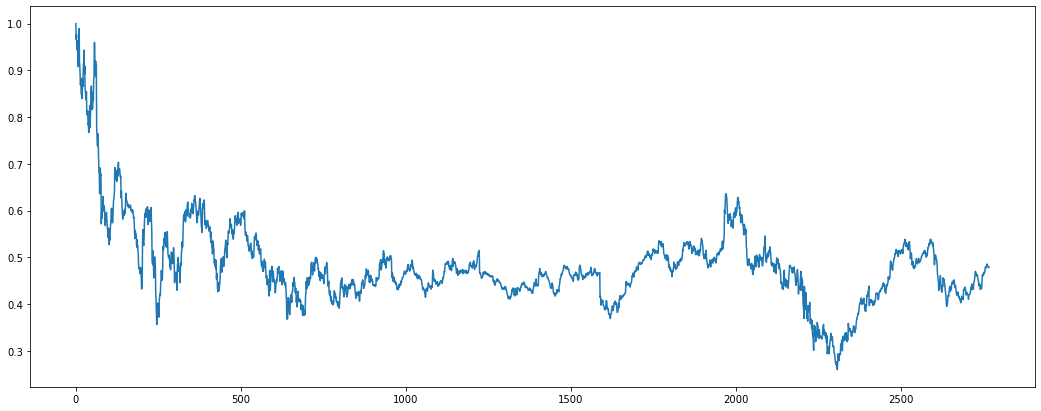

In [10]:
plt.figure(figsize=(18,7))
plt.plot(msft_train.close)
plt.show()

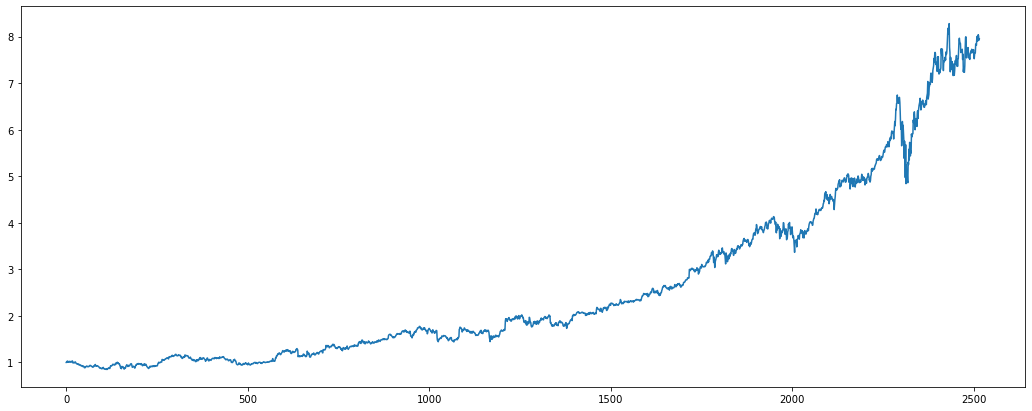

In [11]:
plt.figure(figsize=(18,7))
plt.plot(msft_test.close)
plt.show()

In [12]:
env = EAM_Env(msft_train, reward_on_close=True)

In [13]:
input_shape = [22, 50]
n_outputs = 3

In [14]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv1D(filters, 3, strides=strides,
                               padding='same', use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv1D(filters, 3, strides=1,
                               padding='same', use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv1D(filters, 1, strides=strides,
                                   padding='same', use_bias=False),
                keras.layers.BatchNormalization()]
            
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [16]:
K = keras.backend
input_states = keras.layers.Input(shape=input_shape)
hidden1 = keras.layers.Conv1D(64, 7, strides=2, input_shape=[22,50],
                             padding='same', use_bias=False)(input_states)
hidden2 = keras.layers.BatchNormalization()(hidden1)
hidden3 = keras.layers.Activation('relu')(hidden2)
hidden4 = keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same')(hidden3)
resunit1 = ResidualUnit(64, strides=1)(hidden4)
resunit2 = ResidualUnit(64, strides=1)(resunit1)
resunit3 = ResidualUnit(64, strides=1)(resunit2)
resunit4 = ResidualUnit(128, strides=2)(resunit3)
resunit5 = ResidualUnit(128, strides=1)(resunit4)
resunit6 = ResidualUnit(128, strides=1)(resunit5)
resunit7 = ResidualUnit(128, strides=1)(resunit6)
resunit8 = ResidualUnit(256, strides=2)(resunit7)
resunit9 = ResidualUnit(256, strides=1)(resunit8)
resunit10 = ResidualUnit(256, strides=1)(resunit9)
resunit11 = ResidualUnit(256, strides=1)(resunit10)
resunit12 = ResidualUnit(256, strides=1)(resunit11)
resunit13 = ResidualUnit(256, strides=1)(resunit12)
resunit14 = ResidualUnit(512, strides=2)(resunit13)
resunit15 = ResidualUnit(512, strides=1)(resunit14)
resunit16 = ResidualUnit(512, strides=1)(resunit15)
hidden5 = keras.layers.GlobalAvgPool1D()(resunit16)
flat = keras.layers.Flatten()(hidden5)
#dense_value = keras.layers.Dense(256, activation='elu', kernel_initializer='he_uniform')(flat)
#dense_adv = keras.layers.Dense(256, activation='elu', kernel_initializer='he_uniform')(flat)
state_values = keras.layers.Dense(1)(flat)
raw_advantages = keras.layers.Dense(n_outputs)(flat)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)#isnt it mean instead of max
Q_values = state_values + advantages
model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

In [17]:
target = keras.models.Model(inputs=[input_states], outputs=[Q_values])
target.set_weights(model.get_weights())

In [16]:
#K = keras.backend
#model = keras.models.Sequential()
#model.add(keras.layers.Conv1D(64, 7, strides=2, input_shape=[22,50],
#                             padding='same', use_bias=False))
#model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Activation('relu'))
#model.add(keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'))
#prev_filters = 64
#for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
#    strides = 1 if filters == prev_filters else 2
#    model.add(ResidualUnit(filters, strides=strides))
#    prev_filters = filters
#model.add(keras.layers.GlobalAvgPool1D())
#model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(3))

In [18]:
#target = keras.models.Sequential()
#target.add(keras.layers.Conv1D(64, 7, strides=2, input_shape=[22,50],
#                             padding='same', use_bias=False))
#target.add(keras.layers.BatchNormalization())
#target.add(keras.layers.Activation('relu'))
#target.add(keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'))
#prev_filters = 64
#for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
#    strides = 1 if filters == prev_filters else 2
#    target.add(ResidualUnit(filters, strides=strides))
#    prev_filters = filters
#target.add(keras.layers.GlobalAvgPool1D())
#target.add(keras.layers.Flatten())
#target.add(keras.layers.Dense(3))
#target.set_weights(model.get_weights())

In [18]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.choice(3, 1, p=[24/49, 24/49, 1/49])[0]
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [ ]:
#def ucb1(state, t, skips=1e-7, buys=1e-7, closes):
    

In [20]:
#class ReplayMemory:
 #   def __init__(self, max_size):
  #      self.buffer = np.empty(max_size, dtype=object)
   #     self.max_size = max_size
    #    self.index = 0
     #   self.size = 0

   #def append(self, obj):
    #    self.buffer[self.index] = obj
     #   self.size = min(self.size + 1, self.max_size)
     #   self.index = (self.index + 1) % self.max_size

#    def sample(self, batch_size):
 #       indices = np.random.randint(self.size, size=batch_size)
  #      return self.buffer[indices]

In [17]:
def sample_experiences(batch_size=50):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, n_states, dones, rewards2, n2_states, dones2 = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(8)]
    return states, actions, rewards, n_states, dones, rewards2, n2_states, dones2

In [18]:
def play_two_steps(env, state, epsilon, action, add_to_buffer=True):
    if action is np.nan:
        action = epsilon_greedy_policy(state, epsilon)
    pass_on1 = True
    n_state, reward, done, info = env.step(action, pass_on1)

    action2 = epsilon_greedy_policy(n_state, epsilon)
    pass_on2 = False
    n2_state, reward2, done2, info2 = env.step(action2, pass_on2)
    
    if add_to_buffer:
        replay_buffer.append((state, action, reward[0], n_state, done, reward2[0], n2_state, done2))
    return n_state, reward, done, info, info2, action2

In [19]:
batch_size = 50
discount_factor = 0.986233
optimizer = keras.optimizers.Adam(learning_rate=5e-4)
loss_fn = keras.losses.mean_squared_error

In [20]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, n_states, dones, rewards2, n2_states, dones2 = experiences
    next_Q_values = model.predict(n_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(n_states) * next_mask).sum(axis=1)
    
    next2_Q_values = model.predict(n2_states)
    best_next2_actions = np.argmax(next2_Q_values, axis=1)
    next2_mask = tf.one_hot(best_next2_actions, n_outputs).numpy()
    next2_best_Q_values = (target.predict(n2_states) * next2_mask).sum(axis=1)
    target_Q_values = (rewards + (1-dones) * discount_factor * rewards2 + 
                      (1-dones2) * (discount_factor ** 2) * next2_best_Q_values )
    
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

In [21]:
start = 10
iterations = 64
update_steps = 10
episodes = 625
episode_chunks = 5

In [24]:
with pd.HDFStore('eam_training.h5') as store:
    replay_buffer_series = store['EAM/msft/reward_on_close/finalreward/training406/replaybuffer']

In [29]:
replay_buffer = [] 
#replay_buffer_series.tolist()

In [26]:
with pd.HDFStore('eam_progress.h5') as store:
    arr_list = store['eam/msft/arr/training406']
    reward_list = store['eam/msft/reward/training406']
    raw_return = store['eam/msft/raw_return/training406']

In [27]:
arr_list = arr_list.tolist()
reward_list = reward_list.tolist()
raw_return = raw_return.tolist()

In [19]:
model.load_weights('EAM_msft_finalreward2_best_500episodes.h5')
target.set_weights(model.get_weights())

In [30]:
reward_list = []
arr_list = []
raw_return = []
loss_list = []
best_reward = -np.inf
close_dicts = []
#actions_list = []
#buy_dicts = []

In [24]:
def one_cycle(i, max_length, start, max_):
    midway = 0.4*max_length
    almost = 0.8*max_length
    if i <= midway:
        lr = (((4.5e-7)/250)*i + 5e-8)
    elif (i > midway) & (i <= almost):
        lr = (((4.5e-7)/250)*(-i) - 5e-8 + 1e-6)
    elif (i > almost) & (i <= max_length):
        lr = ((-3.96e-10)*i) + 2.48e-7
 
    return lr

In [25]:
def exp_lr(episode, start_lr, end_lr, episodes):
    num = start_lr/end_lr
    num2 = np.log(num) / episodes
    return (start_lr * np.exp((-episode)*num2))

In [31]:
for episode in range(0, 5):
    reward_sofar = 1
    reward_mean = 0
    done = False
    action = np.nan
    next_action = np.nan
    losses = 0
    num_steps = 0
    closes = {}
    #buys = {}
    
    #optimizer = keras.optimizers.Adam(one_cycle(episode, episodes))
    optimizer = keras.optimizers.Adam(exp_lr(episode, 5e-4, 5e-7, episodes))
    
    for i in range(1):
        obs = env.reset()
        while not done:
            #epsilon = max(min(1 - episode / 500, 1), 0.01)
            epsilon = max(min(np.exp(-episode/128),1),0.01)
        
            obs, reward, done, info, info2, next_action = play_two_steps(env, obs, epsilon, action)
            #actions_list.append(next_action)
        
            #if action == 1:
                #buys[info['offset']] = reward
        
            if action == 2:
                closes[info['offset']] = reward
                if reward[1] > 0:
                    reward_sofar *= reward[1]
        
            reward_mean += reward[0]/100
            action = next_action
            num_steps += 1
        #action = np.nan
        #next_action = np.nan
        #done = False
        
    reward_mean = reward_mean/num_steps
    arr = (reward_sofar ** (1/(num_steps/252)))
    arr_list.append(arr)
    raw_return.append(reward_sofar)
    close_dicts.append(closes)
    reward_list.append(reward_mean)
    #buy_dicts.append(buys)
    
    #reward_list.append(reward_geomean)
    
    if arr >= best_reward:
        best_weights = model.get_weights()
        best_reward = reward_sofar
        
    if (episode+1) % 25 == 0:
        update_weights = model.get_weights()
        
    if episode > 500:
        if (len(arr_list) - np.argmax(arr_list) - 1) > 25:
            break
        
    if episode >= 0:
        for i in range(iterations):
            losses += training_step(batch_size)
            loss_list.append(losses)
            
        if episode % update_steps == 0:
            target.set_weights(model.get_weights())
            
    if len(replay_buffer) >= 200000:
        for i in range(1660):
            replay_buffer.pop(0)
    
    print('Episode: {}, Steps: {}, epsilon: {}, ARR: {}, Raw_return: {}, Reward_mean: {}'.format(episode, num_steps, 
                                                                                round(epsilon,3), round(arr,4), round(reward_sofar,4), round(reward_mean, 6)))
    print('Learning_rate: {}'.format(exp_lr(episode, 5e-4, 5e-7, episodes)))

2/2 [==============================] - 0s 14ms/step
Episode: 0, Steps: 1421, epsilon: 1.0, ARR: 0.9578, Raw_return: 0.7842, Reward_mean: 0.061017
Learning_rate: 0.0005
2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


KeyboardInterrupt: 

In [1]:
plt.figure(figsize=(18,7))
plt.plot(reward_list)
plt.axhline(y = 0, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.show()

NameError: name 'plt' is not defined

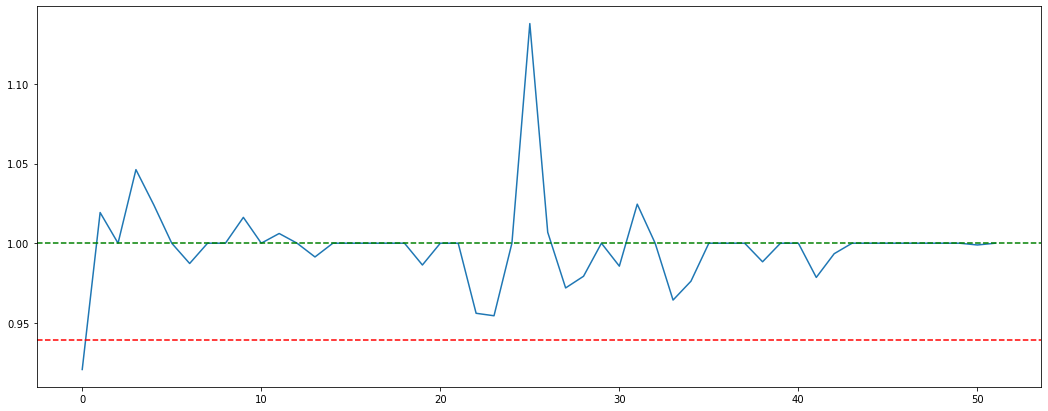

In [31]:
plt.figure(figsize=(18,7))
plt.plot(arr_list)
plt.axhline(y = 1, color = 'green', linestyle ='--')
plt.axhline(y = 0.939, color = 'r', linestyle = '--')
plt.show()

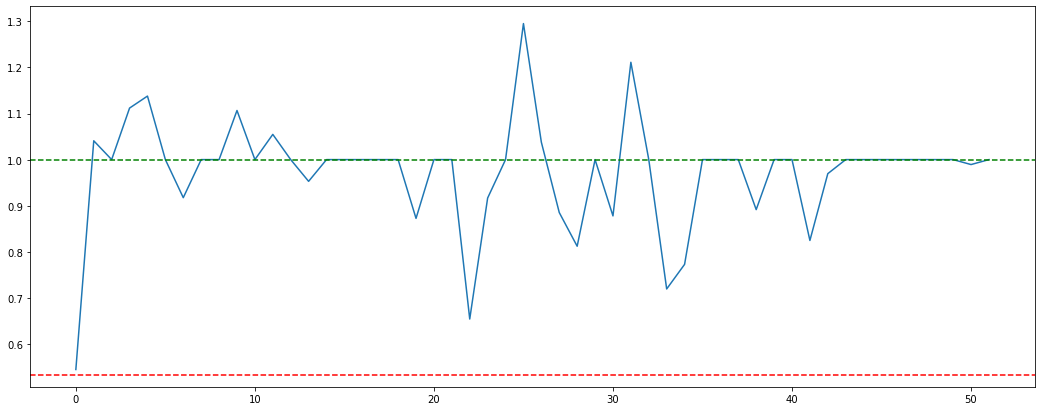

In [32]:
plt.figure(figsize=(18,7))
plt.plot(raw_return)
plt.axhline(y = 1, color = 'green', linestyle = '--')
plt.axhline(y = 0.533, color = 'r', linestyle = '--')
plt.show()

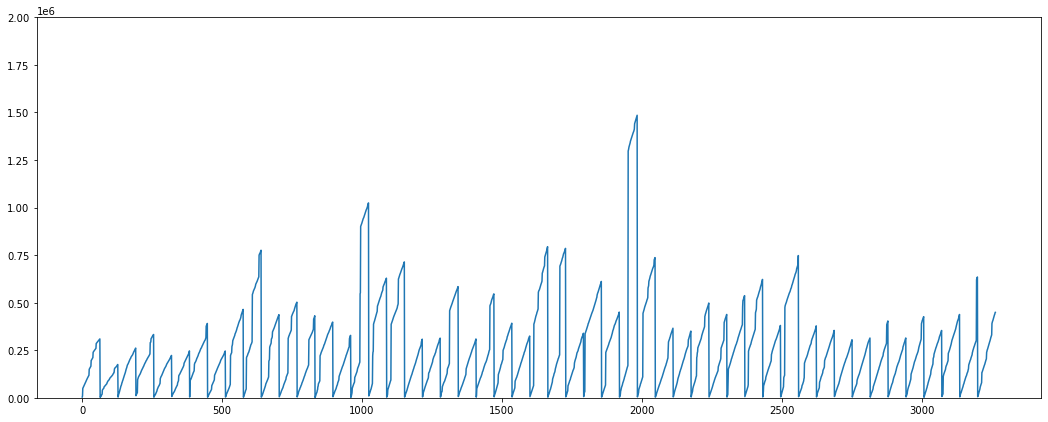

In [33]:
plt.figure(figsize=(18,7))
plt.plot(loss_list)
plt.ylim(0,2e6)
plt.show()

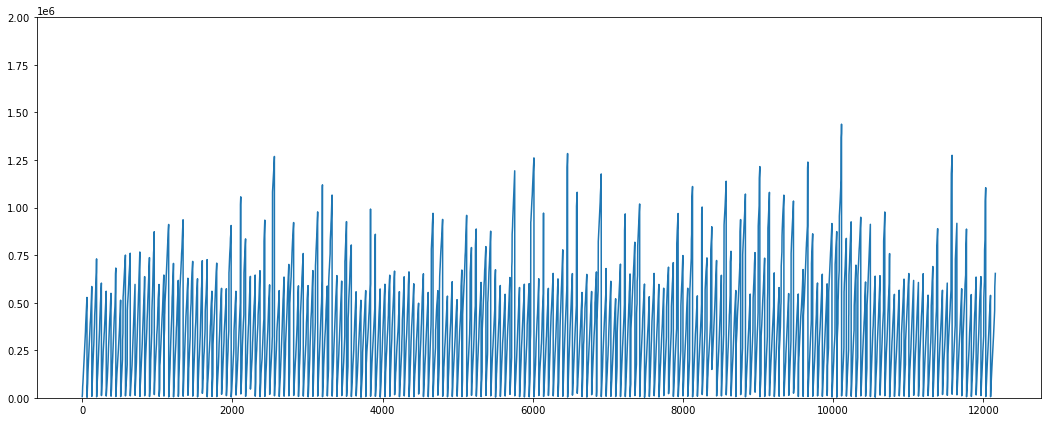

In [34]:
plt.figure(figsize=(18,7))
plt.plot(loss_list)
plt.ylim(0,2e6)
plt.show()

In [70]:
reward_series = pd.Series(reward_list)
arr_series = pd.Series(arr_list)
raw_series = pd.Series(raw_return)

NameError: name 'reward_list' is not defined

In [42]:
with pd.HDFStore('eam_progress.h5') as store:
    store.put('eam/msft/reward/training406', reward_series)
    store.put('eam/msft/arr/training406', arr_series)
    store.put('eam/msft/raw_return/training406', raw_series)

In [35]:
np.argmax(arr_list)

305

In [34]:
model.set_weights(best_weights)

In [75]:
train_start = '2010-12-31'
valid_start = '2016-12-31'
test_start = '2018-12-31'

In [138]:
jnj_sam_valid = jnj_test.loc[(jnj_test['date'] > valid_start) & (jnj_test['date'] <= test_start)]

In [23]:
msft_sam_test = msft_test[msft_test.date > '2018-12-31']

In [40]:
dis_sam_test = dis_test[dis_test.date > '2018-12-31']

In [50]:
jnj_sam_test = jnj_test[jnj_test.date > '2018-12-31']

In [139]:
jnj_sam_valid.reset_index(inplace=True, drop=True)

In [136]:
dis_sam_test.head()

,date,close,high,low,open,volume,tic,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2019-01-02,2.881280,2.872105,2.863637,2.864335,1.280925,DIS,0.232504,0.179,0.037445,...,0.556833,0.227984,3.714723,3.072569,1.241623,0.508067,1.043713,0.859171,0.093782,0.187590
1,2019-01-03,2.811475,2.859211,2.816055,2.874404,1.395692,DIS,0.232504,0.179,0.037445,...,0.556833,0.227984,3.714723,3.072569,1.241623,0.508067,1.043713,0.854679,0.093292,0.188576
2,2019-01-04,2.898202,2.914474,2.850877,2.860095,1.333527,DIS,0.232504,0.179,0.037445,...,0.556833,0.227984,3.714723,3.072569,1.241623,0.508067,1.043713,0.860243,0.093899,0.187356
3,2019-01-07,2.923321,2.931579,2.905370,2.912295,0.884561,DIS,0.232504,0.179,0.037445,...,0.556833,0.227984,3.714723,3.072569,1.241623,0.508067,1.043713,0.861824,0.094071,0.187013
4,2019-01-08,2.946060,2.962105,2.955077,2.962374,1.150138,DIS,0.232504,0.179,0.037445,...,0.556833,0.227984,3.714723,3.072569,1.241623,0.508067,1.043713,0.863243,0.094226,0.186705


In [45]:
msft_sam_test.head()

,date,close,high,low,open,volume,tic,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2019-01-02,3.614010,3.610717,3.543696,3.549020,0.661055,MSFT,0.333828,0.284996,0.099198,...,2.801415,2.443661,12.158893,4.755825,3.144486,0.639685,1.775352,1.361743,0.373046,0.099647
1,2019-01-03,3.481058,3.555358,3.481375,3.568627,0.796708,MSFT,0.333828,0.284996,0.099198,...,2.801415,2.443661,12.158893,4.755825,3.144486,0.639685,1.775352,1.350686,0.370017,0.100462
2,2019-01-04,3.642959,3.637686,3.543338,3.555080,0.824429,MSFT,0.333828,0.284996,0.099198,...,2.801415,2.443661,12.158893,4.755825,3.144486,0.639685,1.775352,1.364096,0.373691,0.099475
3,2019-01-07,3.647605,3.664656,3.616762,3.623529,0.667170,MSFT,0.333828,0.284996,0.099198,...,2.801415,2.443661,12.158893,4.755825,3.144486,0.639685,1.775352,1.364472,0.373794,0.099447
4,2019-01-08,3.674053,3.689496,3.642908,3.673440,0.589674,MSFT,0.333828,0.284996,0.099198,...,2.801415,2.443661,12.158893,4.755825,3.144486,0.639685,1.775352,1.366603,0.374377,0.099292


In [78]:
def front_back_normalizer(dataframe, columns):
    data = dataframe.copy()
    for column in columns:
        day_one = data.at[0, column]
        data[column] = data[column].apply(lambda x: x/day_one)
    return data

In [140]:
columns = ['close', 'high', 'low', 'open', 'volume']
norm_jnj_sam_valid = front_back_normalizer(jnj_sam_valid, columns)

In [97]:
model.load_weights('EAM_msft_rewardonclose_fixed0_250episodes.h5') #this is the one THIS ONE

In [141]:
full_run_env = EAM_Env(norm_jnj_sam_valid, random_ofs_on_reset=False)

In [145]:
obs = full_run_env.reset()
reward_sofar = 1
reward_mean = 0
done = False
action = np.nan
next_action = np.nan
actions = []
num_steps = 0
closes_valid = {}
reward_list_no_close = []
reward_list_close = []
while not done:
        epsilon = 0
        if num_steps != 2715:
            obs, reward, done, info, info2, next_action = play_two_steps(full_run_env, obs, epsilon, action, add_to_buffer=False)
        else:
            obs, reward, done, info, info2, next_action = play_two_steps(full_run_env, obs, epsilon, 2, add_to_buffer=False)
        reward_list_no_close.append(reward[0]/100)
        
        if action == 2:
            closes_valid[info['offset']] = reward
            if reward[1] > 0:
                reward_sofar *= reward[1]
                reward_list_close.append(reward[1])
            else:
                reward_list_close.append(1)
        else:
            reward_mean += reward[0]/100
            reward_list_close.append(1)
        actions.append(next_action)    
        action = next_action
        num_steps += 1
        
arr = (reward_sofar ** (1/(num_steps/252)))
reward_mean = reward_mean/num_steps

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


In [83]:
arr

1.0

In [84]:
reward_mean

0.5955130851558437

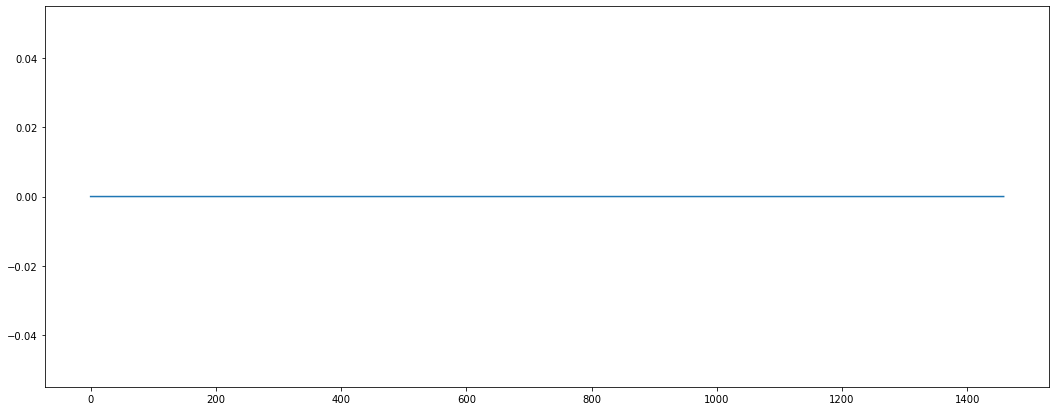

In [131]:
plt.figure(figsize=(18,7))
plt.plot(reward_list_no_close)
plt.show()

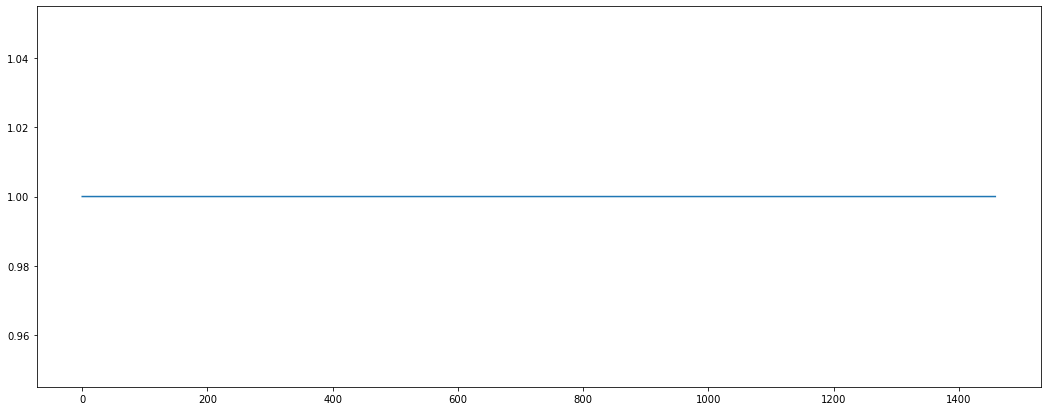

In [86]:
plt.figure(figsize=(18,7))
plt.plot(reward_list_close)
plt.show()

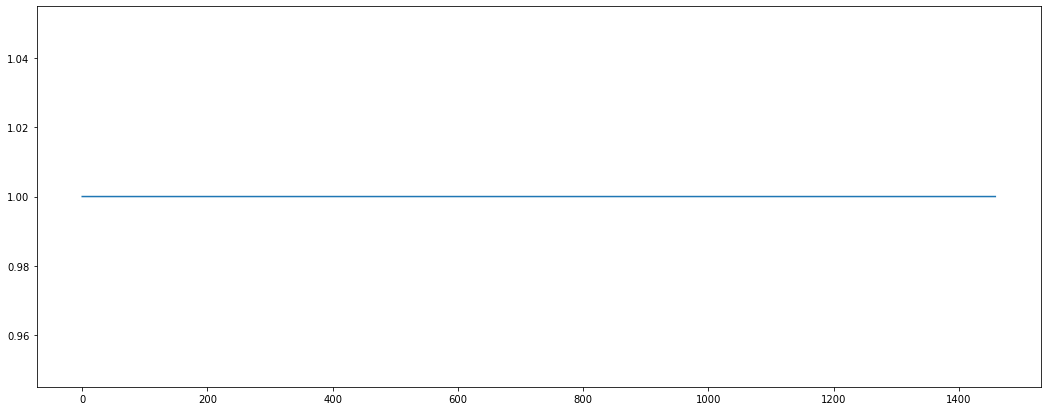

In [87]:
plt.figure(figsize=(18,7))
plt.plot(np.cumprod(reward_list_close))
plt.show()

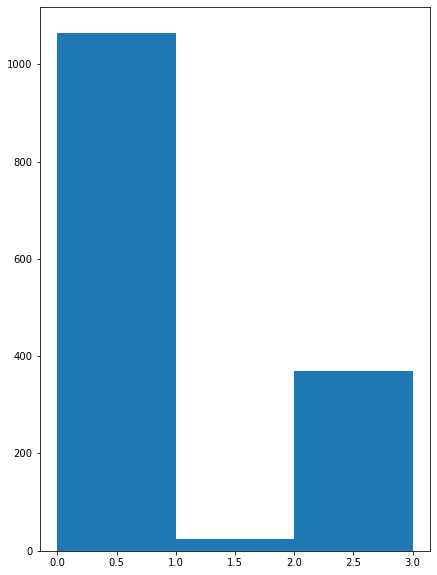

In [89]:
fig, ax = plt.subplots(figsize =(7, 10))
ax.hist(actions, bins = [0,1,2,3])
 
# Show plot
plt.show()

In [90]:
actions

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [91]:
closes_valid

{51: [0.0, 0.0],
 52: [0.0, 0.0],
 53: [0.0, 0.0],
 54: [0.0, 0.0],
 55: [0.0, 0.0],
 56: [0.0, 0.0],
 57: [0.0, 0.0],
 58: [0.0, 0.0],
 59: [0.0, 0.0],
 60: [0.0, 0.0],
 61: [0.0, 0.0],
 62: [0.0, 0.0],
 63: [0.0, 0.0],
 64: [0.0, 0.0],
 65: [0.0, 0.0],
 66: [0.0, 0.0],
 67: [0.0, 0.0],
 68: [0.0, 0.0],
 69: [0.0, 0.0],
 70: [0.0, 0.0],
 71: [0.0, 0.0],
 72: [0.0, 0.0],
 73: [0.0, 0.0],
 74: [0.0, 0.0],
 75: [0.0, 0.0],
 76: [0.0, 0.0],
 77: [0.0, 0.0],
 78: [0.0, 0.0],
 79: [0.0, 0.0],
 80: [0.0, 0.0],
 81: [0.0, 0.0],
 82: [0.0, 0.0],
 83: [0.0, 0.0],
 84: [0.0, 0.0],
 85: [0.0, 0.0],
 86: [0.0, 0.0],
 87: [0.0, 0.0],
 88: [0.0, 0.0],
 89: [0.0, 0.0],
 90: [0.0, 0.0],
 91: [0.0, 0.0],
 92: [0.0, 0.0],
 93: [0.0, 0.0],
 94: [0.0, 0.0],
 95: [0.0, 0.0],
 96: [0.0, 0.0],
 97: [0.0, 0.0],
 98: [0.0, 0.0],
 99: [0.0, 0.0],
 100: [0.0, 0.0],
 101: [0.0, 0.0],
 102: [0.0, 0.0],
 103: [0.0, 0.0],
 104: [0.0, 0.0],
 105: [0.0, 0.0],
 106: [0.0, 0.0],
 107: [0.0, 0.0],
 108: [0.0, 0.0],
 109:

In [92]:
def point_type_listmaker(prices, actions):
    train = prices.loc[51:]
    train.reset_index(inplace=True, drop=True)
    #print(type(prices))
    #print(type(train))
    #print(type(actions))
    train['action'] = actions
    skip_rows = train.loc[train['action'] == 0]
    close_rows = train.loc[train['action'] == 2]
    buy = 1
    
    open_position = []
    for i in range(len(actions)):
        last_close = -1
        if actions[i] == 2:
            last_close = i
        if (buy not in actions[last_close:i]) & (actions[i] == buy):
            open_position.append(i)
            
    buy_rows = train.loc[train['action'] == 1]
    open_rows = train.iloc[open_position]

    return skip_rows, buy_rows, close_rows, open_rows

In [93]:
def eam_plotter(prices, stock, actions):
    plt.plot(prices.date.loc[51:], prices.close.loc[51:], color='black', label='Normalized ' + stock + ' Price')
    
    skips, buys, closes, opens = point_type_listmaker(prices, actions)
    
    plt.scatter(skips.date, skips.close, color='yellow', marker='o', label='Signal-Skipping', alpha=0.3)
    plt.scatter(buys.date, buys.close, color='green', marker='o', label='Signal-Buying', alpha=0.3)
    plt.scatter(closes.date, closes.close, color='red', marker='s', label='Position Closed(Closing)', alpha=0.3)
    #plt.scatter(opens.date, opens.close, color='blue', marker=(5, 1), label='Position Opened(Buying)', alpha=0.2)
    #plt.axvline(xdata=closes.date)
    #plt.axvline(xdata=opens.date)
    
    plt.axis('tight')
    plt.xlabel('Date')
    plt.ylabel('Normalized Stock Price')
    plt.legend()

C:\Users\isaac\AppData\Local\Temp\ipykernel_20400\4208789587.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['action'] = actions


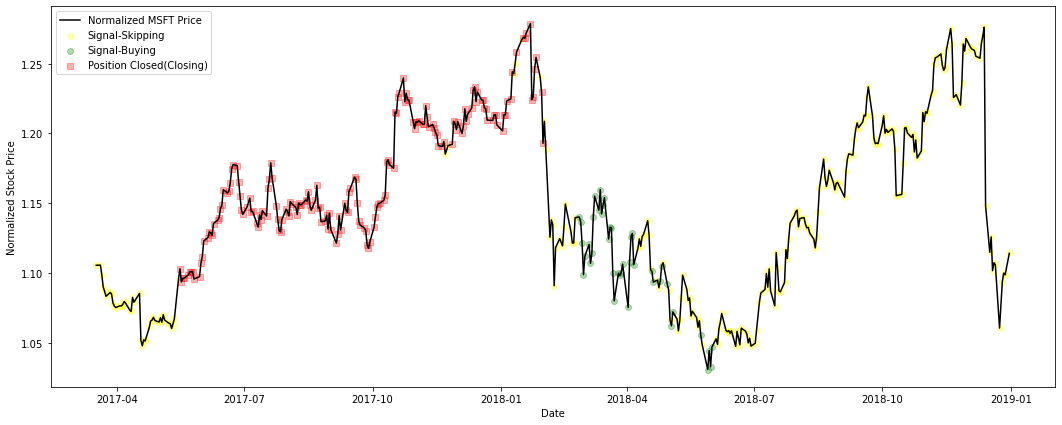

In [146]:
plt.figure(figsize=(18,7))
eam_plotter(norm_jnj_sam_valid, 'MSFT', actions)
plt.show()

In [28]:
update_weights

[array([[[ 1.8567102e-02, -1.5002126e-02, -5.9746351e-02, ...,
           3.0469872e-02, -5.0892159e-02,  3.2839519e-03],
         [-1.9939313e-02, -7.9482824e-02, -6.1106712e-02, ...,
          -7.9919554e-02,  6.0557891e-02,  5.5030208e-02],
         [ 5.5176750e-02,  5.4562856e-02, -2.9002778e-02, ...,
           1.0499782e-02,  6.4336523e-02,  5.8589272e-02],
         ...,
         [ 7.1307659e-02, -1.8950498e-02,  2.4706487e-02, ...,
           5.1919386e-02,  8.1549011e-02,  2.2033410e-02],
         [ 1.3456010e-02,  2.3061160e-02,  1.5214149e-02, ...,
          -2.2562163e-02,  2.8318137e-02,  6.0507681e-02],
         [ 6.6447146e-02,  6.9705702e-02, -6.3305803e-02, ...,
          -6.0193367e-02, -7.7018604e-02, -4.7473960e-02]],
 
        [[-3.6811363e-02, -3.3358511e-02, -4.7612820e-02, ...,
           4.9489565e-02,  2.3053266e-02,  7.9894900e-02],
         [-3.1841062e-02, -3.9101273e-02,  4.6005733e-02, ...,
           5.6708485e-02, -4.8337574e-03,  4.5959696e-02],
       

In [30]:
model.get_weights()

[array([[[ 0.09143138, -0.06642217,  0.08690617, ..., -0.09221029,
           0.06544856,  0.0297385 ],
         [-0.06561082, -0.05100411, -0.07063562, ...,  0.00197704,
           0.06273462,  0.06671958],
         [ 0.08972193,  0.06904981,  0.02842033, ..., -0.07226246,
           0.08036948, -0.04662122],
         ...,
         [ 0.10437862, -0.04128758, -0.03901316, ...,  0.04112639,
           0.05637872, -0.04629534],
         [-0.04357402,  0.10205287, -0.0030519 , ..., -0.01735653,
           0.00358713,  0.07270475],
         [-0.05347779,  0.03894919, -0.024321  , ..., -0.01487381,
           0.12109197,  0.00793558]],
 
        [[ 0.09778976, -0.04708033, -0.06579203, ...,  0.02907547,
           0.08351394,  0.04773458],
         [ 0.06767096,  0.09034327,  0.07421786, ...,  0.0068561 ,
           0.0247105 ,  0.02727576],
         [ 0.0327923 ,  0.03272424, -0.00986399, ..., -0.0252937 ,
          -0.01620805,  0.05790687],
         ...,
         [-0.0283652 ,  0.1102758

In [35]:
model.save_weights('EAM_msft_mixup_finalreward2_550episodes.h5')

In [37]:
model.set_weights(best_weights)
model.save_weights('EAM_msft_finalreward2_best_406episodes.h5')

In [69]:
model.load_weights('EAM_msft_finalreward2_216episodes.h5')

In [38]:
len(replay_buffer)

199986

In [32]:
len(replay_buffer)

200000

In [76]:
replay_buffer = replay_buffer[162676:]

In [39]:
series = pd.Series(replay_buffer)

In [31]:
series.head()

0    ([[0.42346382, 0.42689544, 0.42878285, 0.42294...
1    ([[0.42346382, 0.42689544, 0.42878285, 0.42294...
2    ([[0.42689544, 0.42878285, 0.42294905, 0.43564...
3    ([[0.42878285, 0.42294905, 0.43564612, 0.44542...
4    ([[0.42294905, 0.43564612, 0.44542626, 0.44731...
dtype: object

In [40]:
with pd.HDFStore('eam_training.h5') as store:
    store.put('EAM/msft/reward_on_close/finalreward/training406/replaybuffer', series)

C:\Users\isaac\AppData\Local\Temp\ipykernel_19140\4128141476.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  store.put('EAM/msft/reward_on_close/finalreward/training406/replaybuffer', series)


In [85]:
actions = pd.Series(actions)
with pd.HDFStore('eam_actions.h5') as store:
    store.put('eam/msft/not_real_reward250/test/actions', actions)

In [37]:
actions = pd.Series(actions) #good one
with pd.HDFStore('eam_actions.h5') as store:
    store.put('eam/msft/real_reward_best500/test/actions', actions)

In [49]:
actions = pd.Series(actions) #good one
with pd.HDFStore('eam_actions.h5') as store:
    store.put('eam/dis/real_reward_best500/test/actions', actions)

In [74]:
actions = pd.Series(actions) #meh, all closes
with pd.HDFStore('eam_actions.h5') as store:
    store.put('eam/jnj/real_reward_best500/test/actions', actions)

In [95]:
actions = pd.Series(actions) #goodish one
with pd.HDFStore('eam_actions.h5') as store:
    store.put('eam/msft/real_reward_best500/train/actions', actions)

In [110]:
actions = pd.Series(actions) #good one
with pd.HDFStore('eam_actions.h5') as store:
    store.put('eam/msft/real_reward_best500/valid/actions', actions)

In [117]:
actions = pd.Series(actions) #goodish one
with pd.HDFStore('eam_actions.h5') as store:
    store.put('eam/dis/real_reward_best500/valid/actions', actions)

In [124]:
actions = pd.Series(actions) #good one
with pd.HDFStore('eam_actions.h5') as store:
    store.put('eam/dis/real_reward_best500/train/actions', actions)

In [137]:
actions = pd.Series(actions) #goodish one
with pd.HDFStore('eam_actions.h5') as store:
    store.put('eam/jnj/real_reward_best216/train/actions', actions)

In [147]:
actions = pd.Series(actions) #okay one
with pd.HDFStore('eam_actions.h5') as store:
    store.put('eam/jnj/real_reward_best500/valid/actions', actions)